<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Введение в анализ данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватели ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Семинар 13. Продвинутые методы классификации и регрессии

## Часть 1.  Смешивание алгоритмов для набора данных Titanic. F1-метрика

Продемонстрируем смешивание предсказаний алгоритмов на примере [соревнования](https://www.kaggle.com/c/titanic) Kaggle "Titanic: Machine Learning from a Disaster" и F1-метрики качества. Также в ходе решения будем использовать небольшой "трюк с порогами".

**Подключаем библиотеки.**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from scipy.stats.stats import pearsonr 
import sys
sys.path.append('../../scripts/')
from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


**Считываем данные.**

In [2]:
%%time
X_train, y, X_test = map(np.array, 
                          load_titanic("../../data/titanic_train.csv",
                                   "../../data/titanic_test.csv"))

CPU times: user 325 ms, sys: 7.83 ms, total: 333 ms
Wall time: 362 ms


**Разобьем обучающую выборку на валидационную и проверочную (holdout) части.**

In [3]:
X_valid, X_holdout, y_valid, y_holdout = train_test_split(X_train, y, 
                                                          train_size=0.8, 
                                                          random_state=13)

**Для kNN отшкалируем данные.**

In [4]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
X_valid_scaled, X_holdout_scaled, y_valid_scaled, y_holdout_scaled = \
    train_test_split(X_train_scaled, y, train_size=0.8, random_state=13)

/Users/yorko/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/yorko/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [5]:
shape(X_valid), shape(X_holdout)

((712, 8), (179, 8))

## kNN

**Подберем в процессе кросс-валидации параметр "число соседей", при котором достигается лучшее значение F1-метрики.**

In [6]:
%%time

res = []

neighb = np.arange(1, 70)

for n in neighb:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=n), 
                            X_valid_scaled, y_valid, n_jobs=-1,
                            scoring="f1", cv=5)
    res.append(np.mean(scores))

CPU times: user 4.99 s, sys: 1.86 s, total: 6.84 s
Wall time: 13.2 s


(0.72346094950524675, 13)

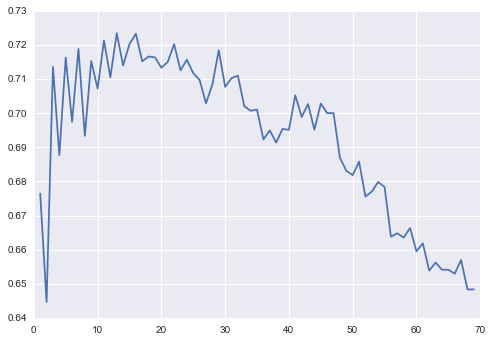

In [7]:
plot(neighb, res)
knn_valid_f1 = max(res)
knn_valid_f1, neighb[np.argmax(res)]

**По умолчанию алгоритм будет относить объекты к классу 1, если предсказанная вероятность отнесения к этому классу >= 0.5. Это вовсе не значит, что порог 0.5 оптимален для данной выборки. Настроим значение порога с помощью кросс-валидации.**

In [8]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

knn = KNeighborsClassifier(n_neighbors=13)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=3, random_state=13)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid_scaled[train_index, :], \
                          X_valid_scaled[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        knn.fit(x_train, y_train)
        scores.append(f1_score((1 - knn.predict_proba(x_test)[:,0]
                                   >= thres)
                                    .astype(int), y_test))
    results.append(np.mean(scores))

Сохраним лучшее среднее значение F1-метрики в процессе кросс-валидации по X_valid с подстройкой порога отсечения в переменной *knn_valid_f1_thres*.

(0.7342153074205271, 0.24999999999999201)

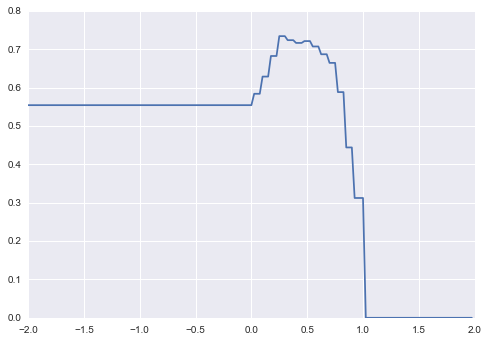

In [9]:
plot(thresholds, results)
knn_valid_thres_f1 = max(results)
knn_valid_thres_f1, thresholds[np.argmax(results)]

In [10]:
print('Validation F1_score with/without threshold tuning', 
      round(knn_valid_thres_f1,4),
     round(knn_valid_f1, 4))

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_valid_scaled, y_valid)
knn_ho_func = 1 - knn.predict_proba(X_holdout_scaled)[:,0]
knn_ho_pred = (knn_ho_func >= 0.25).astype(int)
print('Holdout F1_score with/without threshold tuning', 
      round(f1_score(knn_ho_pred, y_holdout),4),
     round(f1_score(knn.predict(X_holdout_scaled), y_holdout),4))

knn.fit(X_train_scaled, y)
final_knn_pred = (1 - knn.predict_proba(X_test_scaled)[:,0]
                  >= 0.25).astype(int)

Validation F1_score with/without threshold tuning 0.7342 0.7235
Holdout F1_score with/without threshold tuning 0.7792 0.7704


## Линейный SVM

**Обучим LinearSVC с разными параметрами С на X_valid**

In [11]:
%%time

res = []

degrees = np.arange(-5., 5., 0.1)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg, random_state=42), 
                            X_valid, y_valid, n_jobs=-1,
                            scoring="f1", cv=5)
    res.append(np.mean(scores))

CPU times: user 7.77 s, sys: 2.85 s, total: 10.6 s
Wall time: 21.9 s


(0.73069483338329921, -2.2000000000000099)

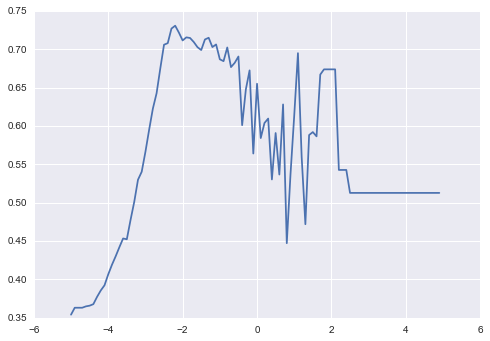

In [12]:
plot(degrees, res)
lin_svc_valid_f1 = max(res)
lin_svc_valid_f1, degrees[list(res).index(max(res))]

**Подберем значения параметра C в более узком диапазоне.**

In [13]:
%%time

res = []

degrees = np.arange(-3, 0, 0.05)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg,
                                      random_state=42), 
                            X_valid, y_valid, n_jobs=-1,
                            scoring="f1", cv=5)
    res.append(np.mean(scores))

CPU times: user 4.43 s, sys: 1.63 s, total: 6.06 s
Wall time: 11.8 s


Сохраним лучшее среднее значение F1-метрики в процессе кросс-валидации по X_valid в переменной *lin_svc_valid_f1*.

(0.73069483338329921, -2.2000000000000028)

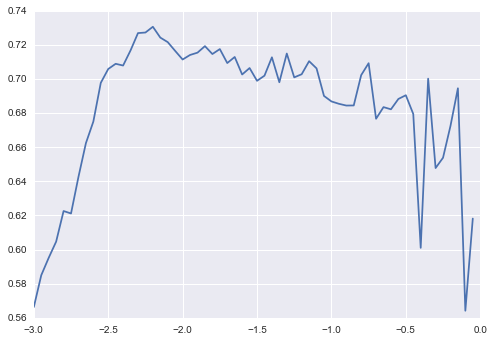

In [14]:
plot(degrees, res)
lin_svc_valid_f1 = max(res)
lin_svc_valid_f1, degrees[list(res).index(max(res))]

**Подберем порог отсечения, максимизирующий f1_score в процессе кросс-валидации.**

In [15]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

lin_svc = LinearSVC(C=10 ** -2.2, random_state=42)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=3, random_state=13)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        lin_svc.fit(x_train, y_train)
        scores.append(f1_score((lin_svc.decision_function(x_test) 
                                   >= thres)
                                    .astype(int), y_test))
    results.append(np.mean(scores))

Сохраним лучшее среднее значение F1-метрики в процессе кросс-валидации по X_valid с подстройкой порога отсечения в переменной *lin_svc_valid_f1_thres*.

(0.73374250110428108, -0.050000000000006928)

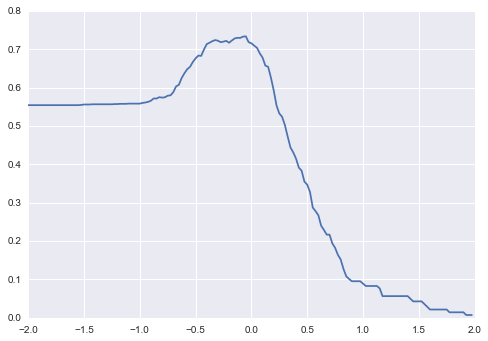

In [16]:
plot(thresholds, results)
lin_svc_valid_thres_f1 = max(results)
lin_svc_valid_thres_f1, thresholds[np.argmax(results)]

**Проверим модель на X_holdout.**

In [17]:
print('Validation F1_score with/without threshold tuning', 
      round(lin_svc_valid_thres_f1,4),
     round(lin_svc_valid_f1, 4))

lin_svc = LinearSVC(C=10 ** -2.2, random_state=42)
lin_svc.fit(X_valid, y_valid)
lin_svc_ho_func = lin_svc.decision_function(X_holdout)
lin_svc_ho_pred = (lin_svc_ho_func >= -0.05).astype(int)
print('Holdout F1_score with/without threshold tuning', 
      round(f1_score(lin_svc_ho_pred, y_holdout),4),
     round(f1_score(lin_svc.predict(X_holdout), y_holdout),4))

lin_svc.fit(X_train, y)
final_svc_pred = (lin_svc.decision_function(X_test) >= -0.05).astype(int)

Validation F1_score with/without threshold tuning 0.7337 0.7307
Holdout F1_score with/without threshold tuning 0.8088 0.797


**Посмотрите, насколько будут коррелировать предсказания  kNN и SVM**

In [18]:
print(pearsonr(final_knn_pred, final_svc_pred))

(0.6806737936918773, 3.462102452826258e-58)


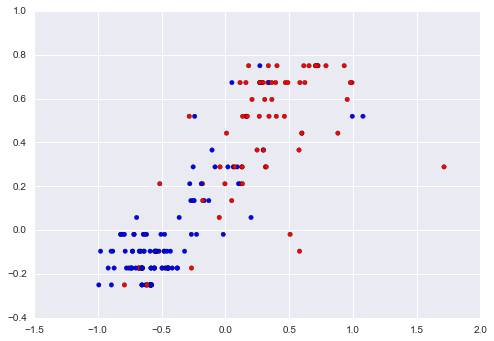

In [19]:
colors = ['red' if i else 'blue' for i in y_holdout]
scatter(lin_svc_ho_func + 0.05,
     knn_ho_func - 0.25, c=colors)

## Смешивание 

**Подберем веса, с которыми будут входить предсказания обученных LinearSVC и KNeighborsClassifier. Подбор проводится за счет кросс-валидации на X_valid**

In [20]:
%%time

knn = KNeighborsClassifier(n_neighbors=13)
lin_svc = LinearSVC(C=10 ** -2.2, random_state=42)

knn_weights = arange(0.0, 1.0, 0.05)
weights = []

res = []

for knn_weight in knn_weights:
    svc_weight = 1 - knn_weight
    weights.append((knn_weight, svc_weight))
    folds = StratifiedKFold(y_valid, n_folds=3,
                               random_state=13)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                              X_valid[test_index, :]
        x_train_scaled, x_test_scaled = X_valid_scaled[train_index, :], \
                              X_valid_scaled[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        knn.fit(x_train_scaled, y_train)
        lin_svc.fit(x_train, y_train)
        predmix = knn_weight * (1 - 
                                    knn.predict_proba(x_test_scaled)[:,0] 
                                - 0.25) +\
        svc_weight * (lin_svc.decision_function(x_test) + 0.05) 

        scores.append(f1_score(y_test, (predmix >= 0.0).astype(int)))
    res.append(np.mean(scores))

CPU times: user 1.45 s, sys: 2.08 ms, total: 1.45 s
Wall time: 1.45 s


(0.73788476716653506, (0.30000000000000004, 0.69999999999999996), 6)

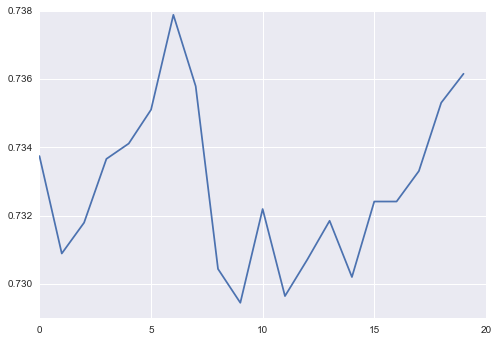

In [21]:
plot(range(len(weights)), res)
mix_valid_f1 = max(res)
max(res), weights[np.argmax(res)], np.argmax(res)

**Проверим модель на X_holdout.**

In [22]:
print('Validation F1_score', 
      round(mix_valid_f1,4))

knn = KNeighborsClassifier(n_neighbors=13)
lin_svc = LinearSVC(C=10 ** -2.2, random_state=42)

knn.fit(X_valid_scaled, y_valid_scaled)
lin_svc.fit(X_valid, y_valid)

pred_mix  = ((0.3 * (1 - knn.predict_proba(X_holdout_scaled)[:,0] - 0.25) + \
        (1. - 0.3) * \
              (lin_svc.decision_function(X_holdout) + 0.05)) >= 0).astype(int)
print('Holdout F1_score', f1_score(pred_mix, y_holdout))

lin_svc.fit(X_train, y)
knn.fit(X_train_scaled, y)

final_pred_mix  = ((0.3 * (1 - knn.predict_proba(X_test_scaled)[:,0] - 0.25) + \
        (1. - 0.3) * \
              (lin_svc.decision_function(X_test) + 0.05)) >= 0).astype(int)

Validation F1_score 0.7379
Holdout F1_score 0.814285714286


## Ссылки
- <a href="http://mlwave.com/kaggle-ensembling-guide/">Тьюториал</a> по применению ансамблей в задачах Kaggle
- <a href="http://download.springer.com/static/pdf/311/art%253A10.1023%252FA%253A1022859003006.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Farticle%2F10.1023%2FA%3A1022859003006&token2=exp=1446024252~acl=%2Fstatic%2Fpdf%2F311%2Fart%25253A10.1023%25252FA%25253A1022859003006.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Farticle%252F10.1023%252FA%253A1022859003006*~hmac=b4d6fcbe0eca42ea30dc0fafffc915f459c6a813671456db685bee0b3a23fe16">Статья</a> "Measures of Diversity in Classifier Ensembles"
- <a href="http://axon.cs.byu.edu/papers/smith.ml2013.pdf">Статья</a> в журнале "Machine learning" "An Instance Level Analysis of Data Complexity"